In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 17,
    "ytick.labelsize": 12
})

## Loading the optimized parameters for M-SGM

In [3]:
new = np.loadtxt("../results/optimized_params.csv",delimiter=",")

new_sorted = new[np.argsort(new[:, len(new[0,:])-1])]

## Distribution of the optimized parameters

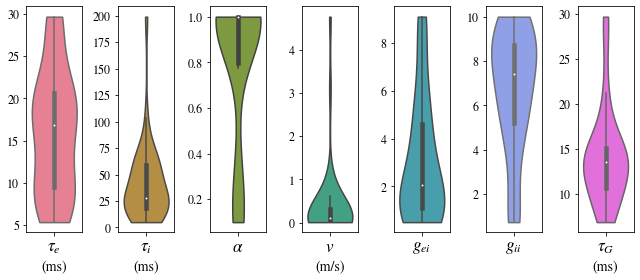

In [4]:
df=pd.DataFrame({r'$\tau_e$':new_sorted[:,0], r'$\tau_i$':new_sorted[:,1], r'$\alpha$':new_sorted[:,2], r'$v$':new_sorted[:,3], r'$g_{ei}$':new_sorted[:,4], r'$g_{ii}$':new_sorted[:,5], r'$\tau_G$':new_sorted[:,6]})

palette = sns.husl_palette(7) 

fig, ax = plt.subplots(1,7, num=1,  gridspec_kw={'width_ratios':[2,2,2,2,2,2,2]}, figsize=(9, 4))

sns.violinplot(data=df[[r'$\tau_e$']], ax=ax[0],color=palette[0],cut=0)
ax[0].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\tau_i$']], ax=ax[1],color=palette[1],cut=0)
ax[1].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\alpha$']], ax=ax[2],color=palette[2],cut=0)
sns.violinplot(data=df[[r'$v$']], ax=ax[3],color=palette[3],cut=0)
ax[3].set_xlabel('(m/s)',fontsize=14)
sns.violinplot(data=df[[r'$g_{ei}$']], ax=ax[4],color=palette[4],cut=0)
sns.violinplot(data=df[[r'$g_{ii}$']], ax=ax[5],color=palette[5],cut=0)
sns.violinplot(data=df[[r'$\tau_G$']], ax=ax[6],color=palette[6],cut=0)
ax[6].set_xlabel('(ms)',fontsize=14)
plt.tight_layout()


## Function to obtain average modeled spectra

In [5]:
# external function from matlab:
def get_mean_C(C):
    #C = np.mean(C, axis = 2)
    C = (C + np.transpose(C))/2
    
    ss = np.argsort(-C[:])
    C = np.minimum(C, ss[int(np.round(0.01*len(ss)))])
    return C

# define data directory
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)


In [6]:
data_dir = path.get_data_path()
## individual connectomes, this is a Nregion x Nregion x Nsubjects array:
ind_conn_xr = xr.open_dataarray(data_dir + '/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

ind_psd_xr = xr.open_dataarray(data_dir + '/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

fvec = ind_psd_xr["frequencies"].values

def getpsd(cdk,rois_with_MEG,fvec,s,df_in):

    C_ind = cdk[:,:,s] # grab current subject's individual connectome

    data_dir = path.get_data_path()
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = C_ind # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brain.distance_matrix = get_mean_C(brain.distance_matrix)

    brain.ntf_params["tau_e"] = df_in[r'$\tau_e$'][s]/1000
    brain.ntf_params["tau_i"] = df_in[r'$\tau_i$'][s]/1000
    brain.ntf_params["alpha"] = df_in[r'$\alpha$'][s]
    brain.ntf_params["speed"] = df_in[r'$v$'][s]
    brain.ntf_params["gei"] = df_in[r'$g_{ei}$'][s]
    brain.ntf_params["gii"] = df_in[r'$g_{ii}$'][s]
    brain.ntf_params["tauC"] = df_in[r'$\tau_G$'][s]/1000

    model_spectrum, _, _, _ = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)

    model_spectrum = model_spectrum[rois_with_MEG,:]
    
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = functions.mag2db(spectrum)
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)

    return filfinal

## Generating the MEG and modeled spectra for comparison

In [7]:
nsubs = len(new_sorted[:,0])
new_spectra = 0
org_spectra_overall = 0

for i in range(nsubs):
    
    spec_predicted = getpsd(ind_conn,rois_with_MEG,fvec,i,df)
    new_spectra += spec_predicted


    org_spectra = 0
    for g in rois_with_MEG:
        spectrum = functions.mag2db(ind_psd[g,:,i])
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra

new_spectra = new_spectra/nsubs
org_spectra_overall = org_spectra_overall/nsubs

## Plotting normalized MEG and modeled average spectra

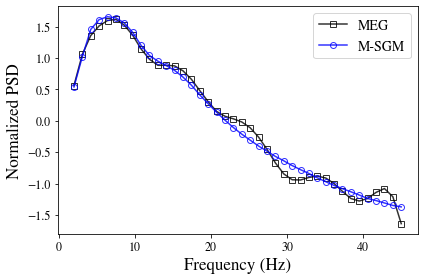

In [8]:
plt.rcParams.update({
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

new_normalized = (new_spectra - np.mean(new_spectra))/(np.std(new_spectra))
org_normalized = (org_spectra_overall - np.mean(org_spectra_overall))/(np.std(org_spectra_overall))

colorp = sns.color_palette("colorblind",n_colors=3)

fig, ax = plt.subplots()


ax.plot(fvec,org_normalized,linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
ax.plot(fvec,new_normalized,linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)

ax.legend(fontsize = 14)
ax.set_xlabel('Frequency (Hz)', fontsize = 17)
ax.set_ylabel('Normalized PSD', fontsize = 17)

plt.tight_layout()